https://www.bilibili.com/video/BV1PX4y1g7KC?p=3

老师说的那个d2l那个库，其实就是一些常用函数写到一个.py文件中了，参考：
<https://github.com/d2l-ai/d2l-zh/blob/master/d2l/torch.py>

# 线性回归内容

In [1]:
%matplotlib inline
import random
import torch

In [2]:
true_w=torch.tensor([2,-3.4])
true_b=4.2

## 生成人造数据

+ 使用线性模型参数$w=[2,-3.4]^T$,$b$=4.2和噪声项$\epsilon$生成数据集及标签
$$\textbf{y}=\textbf{Xw}+b+\epsilon$$
+ （w是二维，说明特征x也是二维）

In [3]:
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))
    # 生成均值为0，方差为1，shape是(num_examples,len(w))的二维数据
    # 样本数为num_examples,每个样本的特征数量是len(w)
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    # 相同维度的矩阵相加，但是产生的这个噪声矩阵也是一个正态分布，
    # 而不是使用一个固定的噪声值
    return X,y.reshape((-1,1))

X是1000\*2维度，则1000\*2  * 2\*1=1000\*1维度，所以y是1000维度

In [4]:
features,labels=synthetic_data(true_w,true_b,1000)

In [5]:
print(f"features:{features[0]},\nlabel:{labels[0]}")

features:tensor([ 0.5677, -0.8166]),
label:tensor([8.1141])


## 可视化样本特征和标签的关系

In [6]:
from IPython import display
from matplotlib import pyplot as plt

display.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5,2.5)

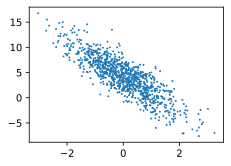

In [7]:
plt.scatter(features[:,1].numpy(),labels.numpy(),1)

## 批量定义

In [8]:
def data_iter(batch_size,features,labels):
    # 获取样本序号列表，麻烦了点
    num_examples=len(features)
    indices=list(range(num_examples))
    # 打乱，后面读取batch中的数据就是随机了
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # 每隔batch_size个读取一个数 使用这个数作为一个batch_size的开始序号，取其后batch_size个数字
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]
        
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,"\n",y)
    break

tensor([[-0.3545, -1.6134],
        [-1.0745,  0.2616],
        [ 0.9680,  0.4065],
        [ 0.8773, -0.2014],
        [ 0.7589,  0.4099],
        [-0.9436, -0.1331],
        [-1.1987, -0.9835],
        [-0.5665, -1.8826],
        [ 1.0736, -0.3864],
        [ 0.7600, -1.1237]]) 
 tensor([[8.9643],
        [1.1724],
        [4.7669],
        [6.6418],
        [4.3308],
        [2.7787],
        [5.1465],
        [9.4540],
        [7.6593],
        [9.5434]])


## 定义初始化模型参数

使用均值为0，方差为0.01的正态分布随机生成w，b是一个初值为0的标量

In [9]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)
print(w,b)

tensor([[ 0.0188],
        [-0.0036]], requires_grad=True) tensor([0.], requires_grad=True)


## 定义模型

也就是建模，对问题进行形式化描述

In [10]:
def linreg(X,w,b):
    """
    line regression model 线性回归模型
    """
    return torch.matmul(X,w)+b

## 定义损失函数

In [11]:
def squared_loss(y_hat,y):
    """
    均方差，差的平方再乘以二分之一
    """
    # 老师的代码给的是reshape过的，我觉得没有必要
    # 后来在比较训练的w和真实w差的时候发现了问题
    return(y_hat-y.reshape(y_hat.shape))**2/2
#     return (y_hat-y)**2/2

## 定义优化算法

In [12]:
def sgd(params,lr,batch_size):
    """
    小批量随机梯度下降 X
    这里说法不严谨，梯度下降法，
    只有批量梯度下降（BGD），
    随机梯度下降（SGD）
    和小批量梯度下降（MBGD）
    """
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            # 这里其实存在一个问题，因为分批的时候，最后一批数据有可能不够batch_size个，这样除的话其实不对
            print(f"参数梯度为：{param.grad}")
            # 注意打印梯度的位置，
            param.grad.zero_()
        print("\n")

    torch.no_grad():
    Context-manager that disabled gradient calculation.
    
 注意：这里要区分，参数，和参数的梯度，
 + `param-=lr*param.grad/batch_size`这句是使用现在求出的参数的梯度，去更新对应的参数
 + 更新后，将梯度置零，这样不影响下次梯度的计算（因为torch默认梯度是累计的）
 + 同时，这里是放在一个`torch.no_grad()`上下文环境中，为的就是让这里那些`requires_grad=True`的向量的梯度，不随着这里的公式进行计算。

## 训练过程

        l=loss(net(X,w,b),y)
        l.sum().backward()
对于这两句代码，
+ 首先，net(X,w,b)会求出一个和y一样含有10个元素的一维向量，
+ 求损失，求出的也是差的向量，可以打印一下看看。
+ 对所有这一批次的数据的损失求和，就是小批量梯度下降的思想了


        l.sum().backward()
        sgd([w,b],lr,batch_size)
   
   
这两句
+ 反向传播，这里计算loss函数中相关参数的梯度，即w和b
+ sgd()主要是体现参数更新的过程，根据计算出的梯度，更新参数，同时将梯度值置零，为下次计算梯度进行梯度更新做准备

In [ ]:
lr=2
num_epoches=3
net=linreg
loss=squared_loss

# 注意 如果更新这些训练参数 需要重新运行一下定义w和b的地方，不然其实初始化是不对的

for epoch in range(num_epoches):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
#         print(f"y_hat:{net(X,w,b)}")
#         print(f"y:{y}")
#         print(f"loss:{l}")
        l.sum().backward()    
        sgd([w,b],lr,batch_size)
#         print(w,b)
    with torch.no_grad():
        # 训练一个epoch（多个batch_size更新了多次梯度之后）的损失
        train_l=loss(net(features,w,b),labels)
        print(f"epoch{epoch+1}, loss {float(train_l.mean()):f}")


---
尝试修改lr，看看，
+ lr很小的时候（如0.001），loss损失降低的非常慢；
+ 0.03的时候降低的很快
+ 如果取lr为10的话，loss为nan，这是因为可能求出的导数非常大
+ lr为1的时候，看起来其实效果也不错
+ lr取2的时候，结果如下：

```
    epoch1, loss 550451296600064.000000
    epoch2, loss 22910926975044506151750205440.000000
    epoch3, loss inf
    epoch4, loss inf
    epoch5, loss inf
    epoch6, loss nan
    epoch7, loss nan
    epoch8, loss nan
    epoch9, loss nan
    epoch10, loss nan
```
+ 这个损失是所有样本的(y_hat-y)**2/2再mean，损失这么大。。。可怕
+ 打印出w和b的梯度之后，看到了更可怕的，所谓的梯度爆炸。。。

----
考虑损失函数对w和b求导的过程(直接看下图也可以)：

$$ \frac{1}{2}\frac{\partial (\hat{y}-y)^2}{\partial w}=\frac{1}{2}\frac{\partial (\langle x,w \rangle+b-y)^2}{\partial w}=\frac{1}{2}\times 2\times (\langle x,w \rangle+b-y) \times \frac{\partial (\langle x,w \rangle+b-y)}{\partial w} =(\langle x,w \rangle+b-y) \times x$$

注意链式求导法则，不要漏了$x^2$得到的2x的x，b同理，但是b就是少了一个乘x

![img](https://img-blog.csdnimg.cn/img_convert/faf6fe0d0cbd65bbaf76bc3d3845d26f.png)

可以看到，
+ 最后损失函数关于w的导数，是和w本身有关的，w的绝对值越大，w的梯度的绝对值就会越大（数量级会越大）。。。。
+ w的分量可能会因为对应x的值有所浮动，但是整体一定是越来越大/越来越小，数量级越来越大！
+ b同理
+ 初始值设置的w很小，远远小于后面计算出的梯度值，以至于当lr为>1的数时，梯度与w相减，已经完全看不到w的影响，完全被梯度盖住了
+ 所以之后计算loss时，w反映出的其实是梯度。。。已经丧失了损失函数最初的意义了

+ [梯度消失和梯度爆炸原因及其解决方案](https://blog.csdn.net/junjun150013652/article/details/81274958)

In [14]:
print(f"w的误差估计：{true_w-w.reshape(true_w.shape)}")
print(f"w的误差估计：{true_b-b}")
# 不进行reshape其实是有问题的

w的误差估计：tensor([-1.1314e+17, -8.1786e+16], grad_fn=<SubBackward0>)
w的误差估计：tensor([-9.8003e+16], grad_fn=<RsubBackward1>)


# 其他内容

## 比较梯度更新时，不同写法的区别

In [1]:
%matplotlib inline
import random
import torch

# 真实模型值
true_w=torch.tensor([2,-3.4])
true_b=4.2

# 生成数据
def synthetic_data(w,b,num_examples):
    X=torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))
features,labels=synthetic_data(true_w,true_b,1000) 

# 生成batch数据
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # 每隔batch_size个读取一个数 使用这个数作为一个batch_size的开始序号，取其后batch_size个数字
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

batch_size=10

# 定义初始化参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

# 定义模型
def linreg(X,w,b):
    return torch.matmul(X,w)+b

# 定义损失函数
def squared_loss(y_hat,y):
    return(y_hat-y.reshape(y_hat.shape))**2/2

In [15]:
id(w) 

140308589009168

In [2]:
w.type

<function Tensor.type>

**id函数不是pytorch才有，是python自带的，这东西就类似这个变量在内存中的地址，如果发生变化，说明重新创建了一个同名的变量**

In [5]:
# 定义优化算法
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            print(f"更新前param的id为：{id(param)}，类型为：{param.type}")
            param-=lr*param.grad/batch_size
            print(f"更新后param的id为：{id(param)},类型为：{param.type}")
            break

In [6]:
# 训练
lr=2
num_epoches=1
net=linreg
loss=squared_loss

for epoch in range(num_epoches):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()    
        sgd([w,b],lr,batch_size)
        break

更新前param的id为：3102546077000，类型为：<built-in method type of Tensor object at 0x000002D25E282548>
更新后param的id为：3102546077000,类型为：<built-in method type of Tensor object at 0x000002D25E282548>


修改梯度更新公式

In [7]:
# 定义优化算法
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            print(f"更新前param的id为：{id(param)}，类型为：{param.type}")
            param=param-lr*param.grad/batch_size
            print(f"更新后param的id为：{id(param)}，类型为：{param.type}")
            break

In [8]:
# 训练
lr=2
num_epoches=1
net=linreg
loss=squared_loss

for epoch in range(num_epoches):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()    
        sgd([w,b],lr,batch_size)
        break

更新前param的id为：3102546077000，类型为：<built-in method type of Tensor object at 0x000002D25E282548>
更新后param的id为：3102274240744，类型为：<built-in method type of Tensor object at 0x000002D24DF440E8>
